In [1]:
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

sys.path.append("../../")

from helpers.split import tag_label_feature_split

DATASET_FOLDER = "../../datasets/"

In [2]:
# read a data set
df = pd.read_pickle(DATASET_FOLDER + "dataset_00_all.pickle")

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1962
)

In [5]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# I am not doing cross validation here.
# I am having problems running train_test_split on the training data.
# Instead I set up folds and then use the first one for my validation data.

skf = StratifiedKFold(n_splits=4)

for train_idx, validate_idx in skf.split(X_train, y_train):
#    X_fold_train, X_fold_validate = X_train_scaled[train_idx], X_train_scaled[validate_idx]
#    y_fold_train, y_fold_validate = y[train_idx], y[validate_idx]
    X_train, X_val = X_train_scaled[train_idx], X_train_scaled[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
  
    smt = SMOTETomek(random_state=1962, n_jobs=-1)
   
    print ("resample")
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)
   
    print ("create classifier")
    classifier = XGBClassifier(
        learning_rate=.221461,
        n_estimators=827,
        max_depth=4,
        gamma=.524969,
        reg_alpha=4.327827,
        use_label_encoder=False,
        tree_method="gpu_hist",
        sampling_method="gradient_based",
        objective="multi:softprob",
        eval_metric=["mlogloss", "auc"], 
        early_stopping_rounds=40,
        seed=1962,
    )

    eval_set = [(X_train_resampled, y_train_resampled), (X_val, y_val)]
    classifier.fit(X_train_resampled, y_train_resampled,
                   eval_set=eval_set, 
                   verbose=False)
    
    break
    

resample
create classifier


**Bayesian Hyperparameter Optimization and SmoteTomek Resampling**

The Bayesian hyperparameter optimizer identified the parameters used for the particular classifier and the use of SmoteTomek resampling.  When I deployed the model, it failed.  Results where nowhere near what the optimizer suggested.  Nevertheless, I want to illusrate the impact of SmoteTomek resampling.  As the plot below shows, we created synthetic training data to boost under represented classes and undersampling to cut back on highly represented classes.  This resampling was applied only to the training data.

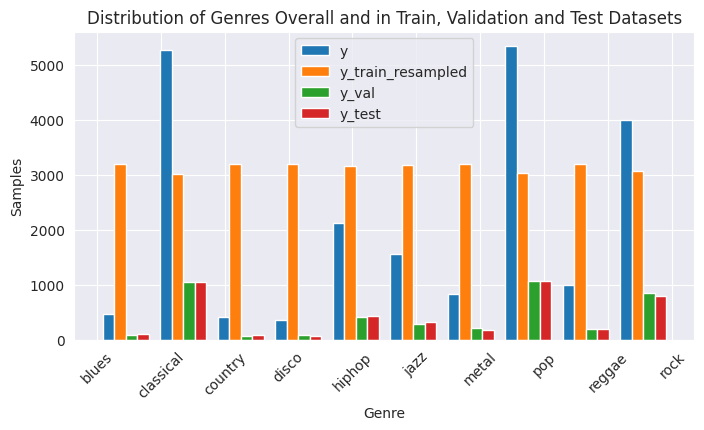

In [16]:
x_labels = [label[6:] for label in le.inverse_transform(range(10))]
plt.figure(figsize=(8,4))
plt.hist([y, y_train_resampled, y_val, y_test],
         label=['y', 'y_train_resampled', 'y_val', 'y_test'])
plt.xticks(range(10), x_labels, rotation=45)
plt.title("Distribution of Genres Overall and in Train, Validation and Test Datasets")
plt.xlabel("Genre")
plt.ylabel("Samples")
plt.legend()
plt.show()

The modeling done with the Bayesian optimizer indicated the following:

```
model                    XGBoostClassifier
dataset              dataset_00_all.pickle
timestamp                       1658136355
scaled                                 yes
pca_components                         0.0
resampling                      SMOTETOMEK
learning_rate                     0.221461
n_estimators                           827
max_depth                                4
gamma                             0.524969
reg_alpha                         4.327827
seed                                  1962
fit_tim                         193.808802
core_tim                           0.37062
matthews_corrcoef                 0.666237
f1_macro                          0.608285
accuracy                          0.729215
```
I am at a loss to understand what went wrong.  Clearly, our results with this particular set of parameters is nowhere near what the optimizer suggested.

In [17]:
test_model = classifier
test_model_results = test_model.evals_result()

In [18]:
train_results=test_model_results['validation_0']
validation_results=test_model_results['validation_1']

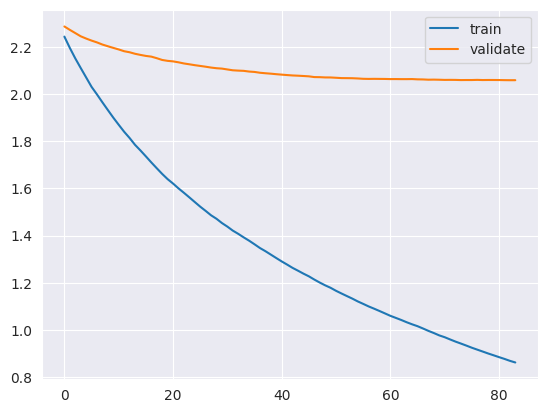

In [10]:
plt.plot(train_results['mlogloss'], label='train')
plt.plot(validation_results['mlogloss'], label='validate')
plt.legend()
plt.show()

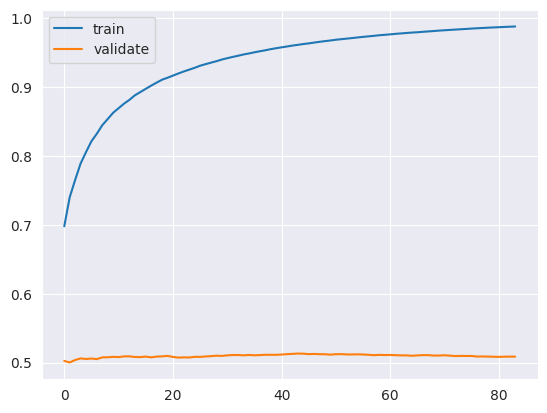

In [11]:
plt.plot(train_results['auc'], label='train')
plt.plot(validation_results['auc'], label='validate')
plt.legend()
plt.show()

In [12]:
accuracy_score(y_test, test_model.predict(X_test_scaled))

0.2299227347225474

In [13]:
matthews_corrcoef(y_test, test_model.predict(X_test_scaled))

0.03920626855513581